<a href="https://colab.research.google.com/github/happyrabbit/TwitterAnalysis/blob/master/TwitterSentimentRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [0]:
# Get a pandas DataFrame object of all the data in the csv file:
df_train = pd.read_csv('https://raw.githubusercontent.com/happyrabbit/TwitterAnalysis/master/Data/TweetsSentiment.csv')


# Remove the blank rows from the series:
df_train = df_train[pd.notnull(df_train['tweet_text'])]

# Get pandas Series object of the "tweet text" column:
# train_x = df_train['tweet_text']
# Get pandas Series object of the "emotion" column:
labels = df_train['is_there_an_emotion_directed_at_a_brand_or_product']

# transform it to be an int category
df_train.loc[ labels == 'Positive emotion', 'labels_int'] = 0
df_train.loc[ labels == 'Negative emotion', 'labels_int'] = 1
df_train.loc[ labels == 'No emotion toward brand or product', 'labels_int'] = 2
df_train.loc[ labels == "I can't tell", 'labels_int'] = 3

X_train, X_test, y_train, y_test = train_test_split(df_train, df_train.labels_int, test_size=0.1)

In [4]:
# set type to be string 
X_train = X_train.tweet_text.astype(str) 
X_test = X_test.tweet_text.astype(str) 

# one hot encode outputs
# y_train = y_train.astype(str)
# y_test = y_test.astype(str)
y_train = to_categorical(y_train, num_classes= 4)
y_test = to_categorical(y_test, num_classes= 4)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# labels = ["Positive emotion", "Negative emotion", "No emotion toward brand or product", "I can't tell"]


(8182,) (8182, 4)
(910,) (910, 4)


In [0]:
# tokenizer = Tokenizer(num_words = 20,oov_token="<oov>")
# tokenizer.fit_on_texts(X_train)
# word_index = tokenizer.word_index
# print(word_index)

In [7]:
vocab_size = 2500
embedding_dim = 128
max_length = 25
trunc_type = 'post'
oov_tok = "<OOV>"

# initialize the tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type, padding = "post")

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length)

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
                             tf.keras.layers.LSTM(64, dropout = 0.2, recurrent_dropout = 0.2, return_sequences=True),
                             tf.keras.layers.LSTM(32),
                             tf.keras.layers.Dense(64, activation = 'relu'),
                             tf.keras.layers.Dense(4, activation= 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 128)           320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 25, 64)            49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 384,196
Trainable params: 384,196
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 10
model_history = model.fit(padded, y_train, epochs = num_epochs, validation_data= (testing_padded, y_test))

Epoch 1/10
256/256 [==============================] - 16s 63ms/step - loss: 0.9261 - accuracy: 0.5991 - val_loss: 0.8563 - val_accuracy: 0.6033
Epoch 2/10
256/256 [==============================] - 16s 62ms/step - loss: 0.7756 - accuracy: 0.6754 - val_loss: 0.8226 - val_accuracy: 0.6264
Epoch 3/10
256/256 [==============================] - 16s 62ms/step - loss: 0.6697 - accuracy: 0.7385 - val_loss: 0.7963 - val_accuracy: 0.6615
Epoch 4/10
256/256 [==============================] - 16s 61ms/step - loss: 0.5954 - accuracy: 0.7710 - val_loss: 0.8114 - val_accuracy: 0.6527
Epoch 5/10
256/256 [==============================] - 16s 61ms/step - loss: 0.5497 - accuracy: 0.7864 - val_loss: 0.8801 - val_accuracy: 0.6484
Epoch 6/10
256/256 [==============================] - 16s 61ms/step - loss: 0.5006 - accuracy: 0.8060 - val_loss: 0.9072 - val_accuracy: 0.6352
Epoch 7/10
256/256 [==============================] - 16s 61ms/step - loss: 0.4671 - accuracy: 0.8191 - val_loss: 0.9547 - val_accuracy:

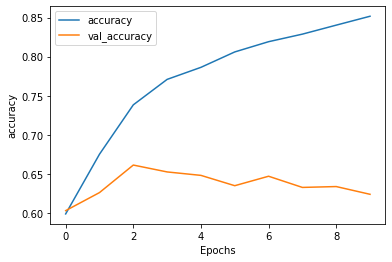

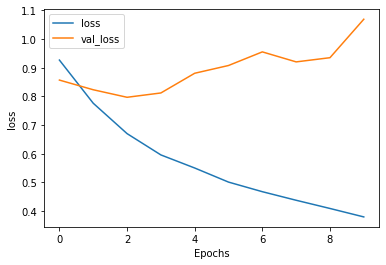

In [9]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(model_history, 'accuracy')
plot_graphs(model_history, 'loss')

In [10]:
predictions = model.predict(testing_padded)
predictions

array([[6.5633876e-04, 1.8925789e-04, 9.9904877e-01, 1.0558117e-04],
       [2.8459904e-01, 2.4081491e-02, 6.5427077e-01, 3.7048619e-02],
       [2.3175988e-01, 5.5047804e-03, 7.5087672e-01, 1.1858612e-02],
       ...,
       [5.3443311e-04, 1.1981034e-03, 9.9777716e-01, 4.9031415e-04],
       [1.1588950e-03, 8.2416902e-04, 9.9761707e-01, 3.9983229e-04],
       [6.2457878e-02, 2.4475220e-01, 4.8552531e-01, 2.0726466e-01]],
      dtype=float32)

In [0]:
df_apply = pd.read_csv('https://raw.githubusercontent.com/happyrabbit/TwitterAnalysis/master/Data/tweets_netlify2020-05-22.csv')
df_apply = df_apply[~df_apply.isRetweet]

In [19]:
df_apply.shape

(5317, 16)

In [0]:
# set type to be string 
x_apply = df_apply.text.astype(str) 

In [0]:
sequences_apply = tokenizer.texts_to_sequences(x_apply)
padded_apply = pad_sequences(sequences_apply, maxlen = max_length, truncating = trunc_type, padding = "post")

In [30]:
padded_apply

array([[   4,    1,   47, ...,    0,    0,    0],
       [ 500,    1,    1, ...,    0,    0,    0],
       [   1,    1,    1, ...,    0,    0,    0],
       ...,
       [   1,    1,    1, ...,    0,    0,    0],
       [   1,    1,    1, ...,    0,    0,    0],
       [   1, 1863,  335, ...,    0,    0,    0]], dtype=int32)

In [0]:
pre_apply = model.predict(padded_apply)

In [0]:
df_res = df_apply.copy()

In [33]:
df_res['Positive_emotion'] = pre_apply[:, 0]
df_res['Negative_emotion'] = pre_apply[:, 1]
df_res['No_emotion'] = pre_apply[:, 2]
df_res['Cant_tell'] = pre_apply[:, 3]
df_res.shape

(5317, 20)

In [0]:
from google.colab import files
df_res.to_csv('twitter_sentiment_res.csv') 
files.download('twitter_sentiment_res.csv')